`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2021/2022`   




# Лабораторная работа №1: Оценка точности модели с непрерывной зависимой переменной

В примере ниже показано:   

* как делить данные на выборки (обучающую и тестовую);  
* как считать MSE: среднеквадратическую ошибку модели;  
* как меняются MSE на тестовой и обучающей выборках с изменением гибкости (числа степеней свободы) модели.  

*Модели*: сглаживающие сплайны.   
*Данные*: сгенерированные.   

## Задание 1

Рассмотрим задание 1: как меняется поведение ошибок на тестовой и обучающей выборках при различном числе степеней свободы, если функция зависимости отклика $Y$ от единственного признака $X$ известна. Сгенерируем $X$ и $Y$:

* $X \sim U(5, 105)$   
* $Y = f(X) + \epsilon$, где $f(X) = 13 + 3.5 \cdot \sin {\frac{x - 30}{9}}$; $\epsilon \sim N(0, 1)$.  

## Задание 2
Повторим расчёты, меняя характеристики согласно варианту 1. Проанализируем, как меняется MSE при изменении характеристик.

* $n\_all = 600$, $n\_all = 550$, $n\_all = 500$

Все выводы и наблюдения описаны далее


---
# Задание 1


### Генерируем исходные данные

In [149]:
# загрузка пакетов
import numpy as np
import random

In [150]:
# задаём ядро генератора случайных чисел (внимание: не глобально)
np.random.seed(10111)

# всего наблюдений, доля обучающей выборки для задания 1
n_all, train_percent = 60, 0.85

# параметры распределения X
x_min, x_max = 5, 105

# генерируем X
x = np.random.uniform(x_min, x_max, n_all)

# генерируем случайный шум
mu, sigma = 0, 1
res = np.random.normal(mu, sigma, n_all)

# отбираем наблюдения в обучающую выборку
in_train = np.random.choice(np.arange(n_all), int(n_all * train_percent), 
                            replace=False)

# истинная функция взаимосвязи
def y_func (x) :
    return(13 + 3.5 * np.sin((x-30)/9))
    
# для графика истинной взаимосвязи
x_line = np.linspace(x_min, x_max, n_all)
y_line = y_func(x_line)

# фактические значения y (с шумом)
y = y_func(x) + res

# создаём векторы с данными для построения графиков
# наблюдения на обучающей выборке
x_train = x[in_train]
y_train = y[in_train]

# наблюдения на тестовой выборке
x_test = np.delete(x, in_train)
y_test = np.delete(y, in_train)



### Строим графики   

Изобразим исходные данные на графике.   

In [151]:
# загрузка пакетов
import matplotlib.pyplot as plt

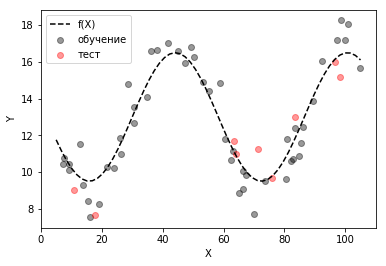

In [152]:
# график 1: исходные данные
#  обучающая выборка
plt.scatter(x_train, y_train, color='black', label='обучение', alpha=0.4)
#  тестовая выборка
plt.scatter(x_test, y_test, color='red', label='тест', alpha=0.4)
#  истинная функция взаимосвязи
plt.plot(x_line, y_line, color='black', linestyle='dashed', label='f(X)')
#  подписи осей
plt.xlabel('X')
plt.ylabel('Y')

#  легенда
plt.legend()
plt.show()

В данном графике мы просто видем большое количество наблюдений на тестовой и обучающей выборках

## Обучаем модели и оцениваем их точность

В качестве модели используем сплайны со степенями свободы от 2 (прямая) до 40 (количество узлов равно 2/3 наблюдений). Строим модели с различным количеством степеней свободы и в каждом случае считаем среднеквадратическую ошибку модели на обучающей и тестовой выборках.    

In [153]:
# загрузка пакетов
from pandas import DataFrame
import rpy2.robjects as robjects

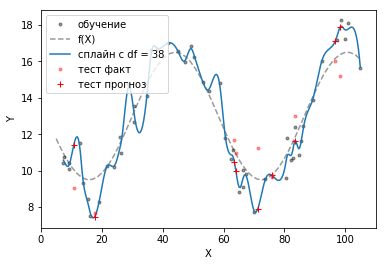

In [154]:
# модель натурального сплайна с заданным количеством узлов (df)
my_df = 38

# сохраняем индексы отсортированного по возрастанию x из обучающей выборки
x_sorted_index = sorted(range(len(x_train)), key=lambda k: x_train[k])

# равноотстоящие координаты по X для прорисовки сглаженной кривой
x_train_lin = np.linspace(min(x_train), max(x_train), num=300, endpoint=True)

# создаём из данных объекты, понятные R
r_x = robjects.FloatVector(x_train)
r_y = robjects.FloatVector(y_train)

# импортируем нужную функцию из R
r_smooth_spline = robjects.r['smooth.spline']

# строим сглаживающий сплайн
fit = r_smooth_spline(x=r_x, y=r_y, df=my_df)

# делаем прогнозы
y_hat_train = np.array(robjects.r['predict'](fit, 
    robjects.FloatVector(x_train)).rx2('y'))
y_hat_test = np.array(robjects.r['predict'](fit, 
    robjects.FloatVector(x_test)).rx2('y'))
y_lin_plot = np.array(robjects.r['predict'](fit, 
    robjects.FloatVector(x_train_lin)).rx2('y'))

# строим график
plt.plot(x_train, y_train, color='black', ls='', marker='.', label='обучение', alpha=0.4)
plt.plot(x_line, y_line, color='black', ls='dashed', marker='', label='f(X)', alpha=0.4)
plt.plot(x_train_lin, y_lin_plot, marker='', label='сплайн с df = %s' % my_df)
plt.plot(x_test, y_test, color='red', ls='', marker='.', label='тест факт', alpha=0.4)
plt.plot(x_test, y_hat_test, color='red', ls='', marker='+', label='тест прогноз')
#  подписи осей
plt.xlabel('X')
plt.ylabel('Y')
# легенда
plt.legend(loc='best')

# считаем MSE
MSE_fit = [sum((y_train - y_hat_train)**2) / len(y_train),
          sum((y_test - y_hat_test)**2) / len(y_test)]

Ошибки на обучающей и тестовой выборках составили соответственно:

In [155]:
# выводим MSE с округлением
np.around(MSE_fit, 2)

array([0.11, 3.32])

In [156]:
#  Теперь строим модели с df от 2 до 40 ########################################

# максимальное число степеней свободы для модели сплайна
max_df = 40

# фрейм данных для сохранения MSE на обучающей и на тестовой 
#  при разных степенях свободы
MSE_all_dfs = [[0] * 2 for i in range(2, max_df+1)]
MSE_all_dfs = DataFrame(MSE_all_dfs, columns=['MSE_train', 'MSE_test'],
                       index=list(range(2, max_df+1)))

# заполняем фрейм
for i_df in range(2, max_df+1) :
    
    # обучаем модель
    fit = r_smooth_spline(x=r_x, y=r_y, df=i_df)
    
    # прогноз на обучающей выборке
    y_train_hat = np.array(robjects.r['predict'](fit, 
        robjects.FloatVector(x_train)).rx2('y'))
    # прогноз на тестовой выборке
    y_test_hat = np.array(robjects.r['predict'](fit, 
        robjects.FloatVector(x_test)).rx2('y'))
    
    # считаем MSE
    MSE_all_dfs.loc[i_df, 'MSE_train'] = sum((y_train - y_train_hat)**2) / len(y_train_hat)
    MSE_all_dfs.loc[i_df, 'MSE_test'] = sum((y_test - y_test_hat)**2) / len(y_test_hat)

Минимум MSE на тестовой выборке достигается при числе степеней свободы:  

In [157]:
# фильтруем таблицу по минимальной MSE на тестовой выборке
MSE_all_dfs[MSE_all_dfs['MSE_test'] == min(MSE_all_dfs['MSE_test'])]

,MSE_train,MSE_test
6,1.412306,1.4239


Изобразим на графике динамику MSE на обучающей и тестовой выборках в зависимости от степеней свободы модели. 

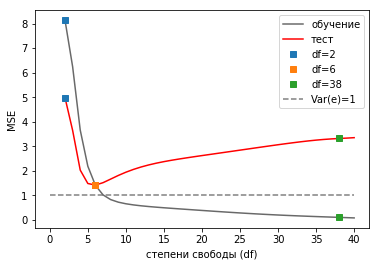

In [158]:
# график изменения MSE с увеличением df
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_train'], color='dimgrey', 
         marker='', label='обучение')
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_test'], color='red', 
         marker='', label='тест')
plt.plot([2, 2], [MSE_all_dfs.iloc[0]['MSE_train'], MSE_all_dfs.iloc[0]['MSE_test']],
         ls='', marker='s', label='df=2')
plt.plot([6, 6], [MSE_all_dfs.iloc[4]['MSE_train'], MSE_all_dfs.iloc[4]['MSE_test']],
         ls='', marker='s', label='df=6')
plt.plot([38, 38], [MSE_all_dfs.iloc[36]['MSE_train'], MSE_all_dfs.iloc[36]['MSE_test']],
         ls='', marker='s', label='df=38')
plt.hlines(1, 0, 40, linestyles='dashed', color='grey', label='Var(e)=1')
#  подписи осей
plt.xlabel('степени свободы (df)')
plt.ylabel('MSE')
# легенда
plt.legend(loc='best')

Кривая MSE на обучающей выборке стабильно снижается с ростом узлов сплайна. Чем больше наблюдений, через которые прошёл сплайн, тем точнее модель. Это говорит о переобучении. Лучшую модель следуют выбирать по минимуму на кривой MSE на тестовой выборке.

## Вывод задача 1:
По гравику можем четко видеть наилучшее число степеней свободы на пересечении, которое равно 6. 

---
# Задание 2
Повторим расчёты, меняя характеристики согласно варианту 1. Проанализируем, как меняется MSE при изменении характеристик.

* $n\_all = 600$, $n\_all = 550$, $n\_all = 500$

Все выводы и наблюдения описаны далее

# $n\_all = 600$

In [159]:
# загрузка пакетов
import numpy as np
import random

In [160]:
# задаём ядро генератора случайных чисел (внимание: не глобально)
np.random.seed(10111)

# всего наблюдений, доля обучающей выборки для задания 2
n_all, train_percent = 600, 0.85

# параметры распределения X
x_min, x_max = 5, 105

# генерируем X
x = np.random.uniform(x_min, x_max, n_all)

# генерируем случайный шум
mu, sigma = 0, 1
res = np.random.normal(mu, sigma, n_all)

# отбираем наблюдения в обучающую выборку
in_train = np.random.choice(np.arange(n_all), int(n_all * train_percent), 
                            replace=False)

# истинная функция взаимосвязи
def y_func (x) :
    return(13 + 3.5 * np.sin((x-30)/9))
    
# для графика истинной взаимосвязи
x_line = np.linspace(x_min, x_max, n_all)
y_line = y_func(x_line)

# фактические значения y (с шумом)
y = y_func(x) + res

# создаём векторы с данными для построения графиков
# наблюдения на обучающей выборке
x_train = x[in_train]
y_train = y[in_train]

# наблюдения на тестовой выборке
x_test = np.delete(x, in_train)
y_test = np.delete(y, in_train)



### Строим графики   

Изобразим исходные данные на графике.   

In [161]:
# загрузка пакетов
import matplotlib.pyplot as plt

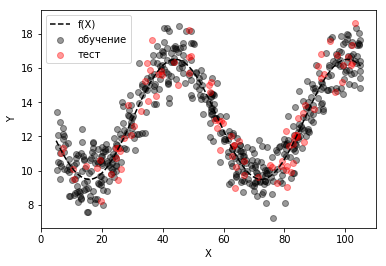

In [162]:
# график 1: исходные данные
#  обучающая выборка
plt.scatter(x_train, y_train, color='black', label='обучение', alpha=0.4)
#  тестовая выборка
plt.scatter(x_test, y_test, color='red', label='тест', alpha=0.4)
#  истинная функция взаимосвязи
plt.plot(x_line, y_line, color='black', linestyle='dashed', label='f(X)')
#  подписи осей
plt.xlabel('X')
plt.ylabel('Y')

#  легенда
plt.legend()
plt.show()

В данном графике мы просто видем большое количество наблюдений на тестовой и обучающей выборках

## Обучаем модели и оцениваем их точность

В качестве модели используем сплайны со степенями свободы от 2 (прямая) до 40 (количество узлов равно 2/3 наблюдений). Строим модели с различным количеством степеней свободы и в каждом случае считаем среднеквадратическую ошибку модели на обучающей и тестовой выборках.    

In [163]:
# загрузка пакетов
from pandas import DataFrame
import rpy2.robjects as robjects

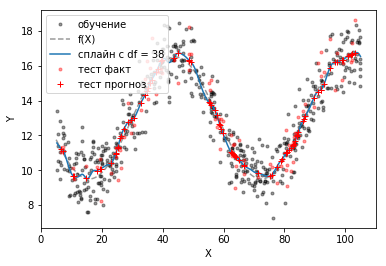

In [164]:
# модель натурального сплайна с заданным количеством узлов (df)
my_df = 38

# сохраняем индексы отсортированного по возрастанию x из обучающей выборки
x_sorted_index = sorted(range(len(x_train)), key=lambda k: x_train[k])

# равноотстоящие координаты по X для прорисовки сглаженной кривой
x_train_lin = np.linspace(min(x_train), max(x_train), num=300, endpoint=True)

# создаём из данных объекты, понятные R
r_x = robjects.FloatVector(x_train)
r_y = robjects.FloatVector(y_train)

# импортируем нужную функцию из R
r_smooth_spline = robjects.r['smooth.spline']

# строим сглаживающий сплайн
fit = r_smooth_spline(x=r_x, y=r_y, df=my_df)

# делаем прогнозы
y_hat_train = np.array(robjects.r['predict'](fit, 
    robjects.FloatVector(x_train)).rx2('y'))
y_hat_test = np.array(robjects.r['predict'](fit, 
    robjects.FloatVector(x_test)).rx2('y'))
y_lin_plot = np.array(robjects.r['predict'](fit, 
    robjects.FloatVector(x_train_lin)).rx2('y'))

# строим график
plt.plot(x_train, y_train, color='black', ls='', marker='.', label='обучение', alpha=0.4)
plt.plot(x_line, y_line, color='black', ls='dashed', marker='', label='f(X)', alpha=0.4)
plt.plot(x_train_lin, y_lin_plot, marker='', label='сплайн с df = %s' % my_df)
plt.plot(x_test, y_test, color='red', ls='', marker='.', label='тест факт', alpha=0.4)
plt.plot(x_test, y_hat_test, color='red', ls='', marker='+', label='тест прогноз')
#  подписи осей
plt.xlabel('X')
plt.ylabel('Y')
# легенда
plt.legend(loc='best')

# считаем MSE
MSE_fit = [sum((y_train - y_hat_train)**2) / len(y_train),
          sum((y_test - y_hat_test)**2) / len(y_test)]

## $\color{red}{\text{Анализ графика для задачи 2}}$

* $n\_all = 600$

Для исходного числа степеней свободы = 38, мы видим, что сплайн достаточно близко подходит к исходной функции f(X), также как и тестовые прогнозы попадают в область значений


Ошибки на обучающей и тестовой выборках составили соответственно:

In [165]:
# выводим MSE с округлением
np.around(MSE_fit, 2)

array([0.94, 0.93])

In [166]:
#  Теперь строим модели с df от 2 до 40 ########################################

# максимальное число степеней свободы для модели сплайна
max_df = 40

# фрейм данных для сохранения MSE на обучающей и на тестовой 
#  при разных степенях свободы
MSE_all_dfs = [[0] * 2 for i in range(2, max_df+1)]
MSE_all_dfs = DataFrame(MSE_all_dfs, columns=['MSE_train', 'MSE_test'],
                       index=list(range(2, max_df+1)))

# заполняем фрейм
for i_df in range(2, max_df+1) :
    
    # обучаем модель
    fit = r_smooth_spline(x=r_x, y=r_y, df=i_df)
    
    # прогноз на обучающей выборке
    y_train_hat = np.array(robjects.r['predict'](fit, 
        robjects.FloatVector(x_train)).rx2('y'))
    # прогноз на тестовой выборке
    y_test_hat = np.array(robjects.r['predict'](fit, 
        robjects.FloatVector(x_test)).rx2('y'))
    
    # считаем MSE
    MSE_all_dfs.loc[i_df, 'MSE_train'] = sum((y_train - y_train_hat)**2) / len(y_train_hat)
    MSE_all_dfs.loc[i_df, 'MSE_test'] = sum((y_test - y_test_hat)**2) / len(y_test_hat)

Минимум MSE на тестовой выборке достигается при числе степеней свободы:  

In [167]:
# фильтруем таблицу по минимальной MSE на тестовой выборке
MSE_all_dfs[MSE_all_dfs['MSE_test'] == min(MSE_all_dfs['MSE_test'])]

,MSE_train,MSE_test
17,0.987517,0.904098


## $\color{red}{\text{Анализ ошибки для задачи 2}}$

* $n\_all = 600$

Для данного числа наблюдений минимальная ошибка находится с числом степеней свободы = 17


Изобразим на графике динамику MSE на обучающей и тестовой выборках в зависимости от степеней свободы модели. 

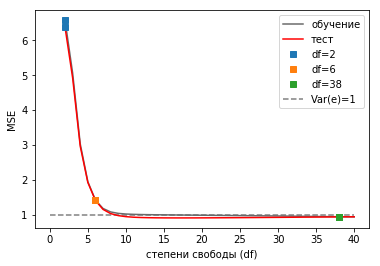

In [168]:
# график изменения MSE с увеличением df
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_train'], color='dimgrey', 
         marker='', label='обучение')
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_test'], color='red', 
         marker='', label='тест')
plt.plot([2, 2], [MSE_all_dfs.iloc[0]['MSE_train'], MSE_all_dfs.iloc[0]['MSE_test']],
         ls='', marker='s', label='df=2')
plt.plot([6, 6], [MSE_all_dfs.iloc[4]['MSE_train'], MSE_all_dfs.iloc[4]['MSE_test']],
         ls='', marker='s', label='df=6')
plt.plot([38, 38], [MSE_all_dfs.iloc[36]['MSE_train'], MSE_all_dfs.iloc[36]['MSE_test']],
         ls='', marker='s', label='df=38')
plt.hlines(1, 0, 40, linestyles='dashed', color='grey', label='Var(e)=1')
#  подписи осей
plt.xlabel('степени свободы (df)')
plt.ylabel('MSE')
# легенда
plt.legend(loc='best')

## $\color{red}{\text{Анализ графика для задачи 2}}$

* $n\_all = 600$

По графику мы можем видеть, что при заданном интервале кол-ва степеней свободы [0;40], наилучшее число степеней свободы равно 17, где графики функций принимают свое минимальное значение.

Кривая MSE на обучающей выборке стабильно снижается с ростом узлов сплайна. Чем больше наблюдений, через которые прошёл сплайн, тем точнее модель. Это говорит о переобучении. Лучшую модель следуют выбирать по минимуму на кривой MSE на тестовой выборке.

---

# $n\_all = 550$

In [169]:
# загрузка пакетов
import numpy as np
import random

In [170]:
# задаём ядро генератора случайных чисел (внимание: не глобально)
np.random.seed(10111)

# всего наблюдений, доля обучающей выборки для задания 2
n_all, train_percent = 550, 0.85

# параметры распределения X
x_min, x_max = 5, 105

# генерируем X
x = np.random.uniform(x_min, x_max, n_all)

# генерируем случайный шум
mu, sigma = 0, 1
res = np.random.normal(mu, sigma, n_all)

# отбираем наблюдения в обучающую выборку
in_train = np.random.choice(np.arange(n_all), int(n_all * train_percent), 
                            replace=False)

# истинная функция взаимосвязи
def y_func (x) :
    return(13 + 3.5 * np.sin((x-30)/9))
    
# для графика истинной взаимосвязи
x_line = np.linspace(x_min, x_max, n_all)
y_line = y_func(x_line)

# фактические значения y (с шумом)
y = y_func(x) + res

# создаём векторы с данными для построения графиков
# наблюдения на обучающей выборке
x_train = x[in_train]
y_train = y[in_train]

# наблюдения на тестовой выборке
x_test = np.delete(x, in_train)
y_test = np.delete(y, in_train)



### Строим графики   

Изобразим исходные данные на графике.   

In [171]:
# загрузка пакетов
import matplotlib.pyplot as plt

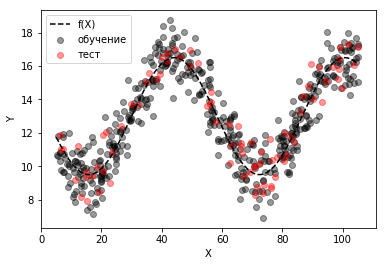

In [172]:
# график 1: исходные данные
#  обучающая выборка
plt.scatter(x_train, y_train, color='black', label='обучение', alpha=0.4)
#  тестовая выборка
plt.scatter(x_test, y_test, color='red', label='тест', alpha=0.4)
#  истинная функция взаимосвязи
plt.plot(x_line, y_line, color='black', linestyle='dashed', label='f(X)')
#  подписи осей
plt.xlabel('X')
plt.ylabel('Y')

#  легенда
plt.legend()
plt.show()

В данном графике мы просто видем большое количество наблюдений на тестовой и обучающей выборках

## Обучаем модели и оцениваем их точность

В качестве модели используем сплайны со степенями свободы от 2 (прямая) до 40 (количество узлов равно 2/3 наблюдений). Строим модели с различным количеством степеней свободы и в каждом случае считаем среднеквадратическую ошибку модели на обучающей и тестовой выборках.    

In [173]:
# загрузка пакетов
from pandas import DataFrame
import rpy2.robjects as robjects

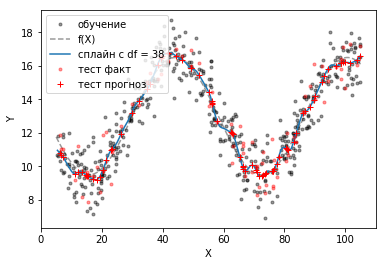

In [174]:
# модель натурального сплайна с заданным количеством узлов (df)
my_df = 38

# сохраняем индексы отсортированного по возрастанию x из обучающей выборки
x_sorted_index = sorted(range(len(x_train)), key=lambda k: x_train[k])

# равноотстоящие координаты по X для прорисовки сглаженной кривой
x_train_lin = np.linspace(min(x_train), max(x_train), num=300, endpoint=True)

# создаём из данных объекты, понятные R
r_x = robjects.FloatVector(x_train)
r_y = robjects.FloatVector(y_train)

# импортируем нужную функцию из R
r_smooth_spline = robjects.r['smooth.spline']

# строим сглаживающий сплайн
fit = r_smooth_spline(x=r_x, y=r_y, df=my_df)

# делаем прогнозы
y_hat_train = np.array(robjects.r['predict'](fit, 
    robjects.FloatVector(x_train)).rx2('y'))
y_hat_test = np.array(robjects.r['predict'](fit, 
    robjects.FloatVector(x_test)).rx2('y'))
y_lin_plot = np.array(robjects.r['predict'](fit, 
    robjects.FloatVector(x_train_lin)).rx2('y'))

# строим график
plt.plot(x_train, y_train, color='black', ls='', marker='.', label='обучение', alpha=0.4)
plt.plot(x_line, y_line, color='black', ls='dashed', marker='', label='f(X)', alpha=0.4)
plt.plot(x_train_lin, y_lin_plot, marker='', label='сплайн с df = %s' % my_df)
plt.plot(x_test, y_test, color='red', ls='', marker='.', label='тест факт', alpha=0.4)
plt.plot(x_test, y_hat_test, color='red', ls='', marker='+', label='тест прогноз')
#  подписи осей
plt.xlabel('X')
plt.ylabel('Y')
# легенда
plt.legend(loc='best')

# считаем MSE
MSE_fit = [sum((y_train - y_hat_train)**2) / len(y_train),
          sum((y_test - y_hat_test)**2) / len(y_test)]

## $\color{red}{\text{Анализ графика для задачи 2}}$

* $n\_all = 550$

Для исходного числа степеней свободы = 38, мы видим, что сплайн близко подходит к исходной функции f(X), но все же кривая слишком ломанная и надо рассмотреть варианты с меньшим числом степеней свободы, тестовые прогнозы попадают в область значений

Ошибки на обучающей и тестовой выборках составили соответственно:

In [175]:
# выводим MSE с округлением
np.around(MSE_fit, 2)

array([0.95, 0.88])

In [176]:
#  Теперь строим модели с df от 2 до 40 ########################################

# максимальное число степеней свободы для модели сплайна
max_df = 40

# фрейм данных для сохранения MSE на обучающей и на тестовой 
#  при разных степенях свободы
MSE_all_dfs = [[0] * 2 for i in range(2, max_df+1)]
MSE_all_dfs = DataFrame(MSE_all_dfs, columns=['MSE_train', 'MSE_test'],
                       index=list(range(2, max_df+1)))

# заполняем фрейм
for i_df in range(2, max_df+1) :
    
    # обучаем модель
    fit = r_smooth_spline(x=r_x, y=r_y, df=i_df)
    
    # прогноз на обучающей выборке
    y_train_hat = np.array(robjects.r['predict'](fit, 
        robjects.FloatVector(x_train)).rx2('y'))
    # прогноз на тестовой выборке
    y_test_hat = np.array(robjects.r['predict'](fit, 
        robjects.FloatVector(x_test)).rx2('y'))
    
    # считаем MSE
    MSE_all_dfs.loc[i_df, 'MSE_train'] = sum((y_train - y_train_hat)**2) / len(y_train_hat)
    MSE_all_dfs.loc[i_df, 'MSE_test'] = sum((y_test - y_test_hat)**2) / len(y_test_hat)

Минимум MSE на тестовой выборке достигается при числе степеней свободы:  

In [177]:
# фильтруем таблицу по минимальной MSE на тестовой выборке
MSE_all_dfs[MSE_all_dfs['MSE_test'] == min(MSE_all_dfs['MSE_test'])]

,MSE_train,MSE_test
14,1.02737,0.814475


## $\color{red}{\text{Анализ ошибки для задачи 2}}$

* $n\_all = 550$

Для данного числа наблюдений минимальная ошибка находится с числом степеней свободы = 14, как и раньше предполагалось, что надо брать меньшее кол-во степеней свободы чем 38

Изобразим на графике динамику MSE на обучающей и тестовой выборках в зависимости от степеней свободы модели. 

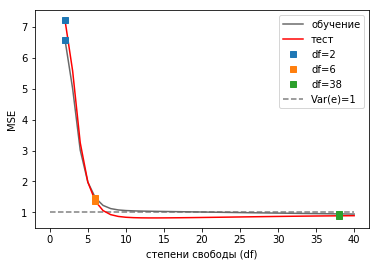

In [178]:
# график изменения MSE с увеличением df
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_train'], color='dimgrey', 
         marker='', label='обучение')
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_test'], color='red', 
         marker='', label='тест')
plt.plot([2, 2], [MSE_all_dfs.iloc[0]['MSE_train'], MSE_all_dfs.iloc[0]['MSE_test']],
         ls='', marker='s', label='df=2')
plt.plot([6, 6], [MSE_all_dfs.iloc[4]['MSE_train'], MSE_all_dfs.iloc[4]['MSE_test']],
         ls='', marker='s', label='df=6')
plt.plot([38, 38], [MSE_all_dfs.iloc[36]['MSE_train'], MSE_all_dfs.iloc[36]['MSE_test']],
         ls='', marker='s', label='df=38')
plt.hlines(1, 0, 40, linestyles='dashed', color='grey', label='Var(e)=1')
#  подписи осей
plt.xlabel('степени свободы (df)')
plt.ylabel('MSE')
# легенда
plt.legend(loc='best')

## $\color{red}{\text{Анализ графика для задачи 2}}$

* $n\_all = 550$

По графику мы можем видеть, что при заданном интервале кол-ва степеней свободы [0;40], наилучшее число степеней свободы действительно равно 14, где графики функций принимают свое минимальное значение.



Кривая MSE на обучающей выборке стабильно снижается с ростом узлов сплайна. Чем больше наблюдений, через которые прошёл сплайн, тем точнее модель. Это говорит о переобучении. Лучшую модель следуют выбирать по минимуму на кривой MSE на тестовой выборке.

---
# $n\_all = 500$

In [179]:
# загрузка пакетов
import numpy as np
import random

In [180]:
# задаём ядро генератора случайных чисел (внимание: не глобально)
np.random.seed(10111)

# всего наблюдений, доля обучающей выборки для задания 2
n_all, train_percent = 500, 0.85

# параметры распределения X
x_min, x_max = 5, 105

# генерируем X
x = np.random.uniform(x_min, x_max, n_all)

# генерируем случайный шум
mu, sigma = 0, 1
res = np.random.normal(mu, sigma, n_all)

# отбираем наблюдения в обучающую выборку
in_train = np.random.choice(np.arange(n_all), int(n_all * train_percent), 
                            replace=False)

# истинная функция взаимосвязи
def y_func (x) :
    return(13 + 3.5 * np.sin((x-30)/9))
    
# для графика истинной взаимосвязи
x_line = np.linspace(x_min, x_max, n_all)
y_line = y_func(x_line)

# фактические значения y (с шумом)
y = y_func(x) + res

# создаём векторы с данными для построения графиков
# наблюдения на обучающей выборке
x_train = x[in_train]
y_train = y[in_train]

# наблюдения на тестовой выборке
x_test = np.delete(x, in_train)
y_test = np.delete(y, in_train)



### Строим графики   

Изобразим исходные данные на графике.   

In [181]:
# загрузка пакетов
import matplotlib.pyplot as plt

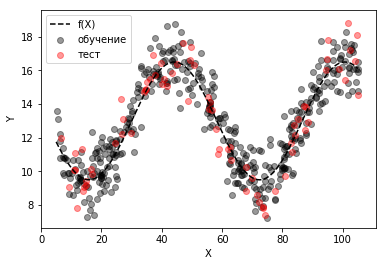

In [182]:
# график 1: исходные данные
#  обучающая выборка
plt.scatter(x_train, y_train, color='black', label='обучение', alpha=0.4)
#  тестовая выборка
plt.scatter(x_test, y_test, color='red', label='тест', alpha=0.4)
#  истинная функция взаимосвязи
plt.plot(x_line, y_line, color='black', linestyle='dashed', label='f(X)')
#  подписи осей
plt.xlabel('X')
plt.ylabel('Y')

#  легенда
plt.legend()
plt.show()

В данном графике мы просто видем большое количество наблюдений на тестовой и обучающей выборках

## Обучаем модели и оцениваем их точность

В качестве модели используем сплайны со степенями свободы от 2 (прямая) до 40 (количество узлов равно 2/3 наблюдений). Строим модели с различным количеством степеней свободы и в каждом случае считаем среднеквадратическую ошибку модели на обучающей и тестовой выборках.    

In [183]:
# загрузка пакетов
from pandas import DataFrame
import rpy2.robjects as robjects

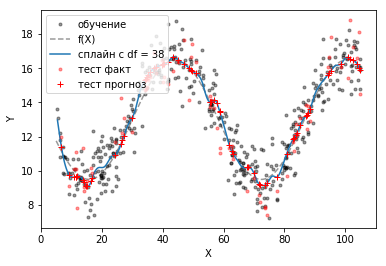

In [184]:
# модель натурального сплайна с заданным количеством узлов (df)
my_df = 38

# сохраняем индексы отсортированного по возрастанию x из обучающей выборки
x_sorted_index = sorted(range(len(x_train)), key=lambda k: x_train[k])

# равноотстоящие координаты по X для прорисовки сглаженной кривой
x_train_lin = np.linspace(min(x_train), max(x_train), num=300, endpoint=True)

# создаём из данных объекты, понятные R
r_x = robjects.FloatVector(x_train)
r_y = robjects.FloatVector(y_train)

# импортируем нужную функцию из R
r_smooth_spline = robjects.r['smooth.spline']

# строим сглаживающий сплайн
fit = r_smooth_spline(x=r_x, y=r_y, df=my_df)

# делаем прогнозы
y_hat_train = np.array(robjects.r['predict'](fit, 
    robjects.FloatVector(x_train)).rx2('y'))
y_hat_test = np.array(robjects.r['predict'](fit, 
    robjects.FloatVector(x_test)).rx2('y'))
y_lin_plot = np.array(robjects.r['predict'](fit, 
    robjects.FloatVector(x_train_lin)).rx2('y'))

# строим график
plt.plot(x_train, y_train, color='black', ls='', marker='.', label='обучение', alpha=0.4)
plt.plot(x_line, y_line, color='black', ls='dashed', marker='', label='f(X)', alpha=0.4)
plt.plot(x_train_lin, y_lin_plot, marker='', label='сплайн с df = %s' % my_df)
plt.plot(x_test, y_test, color='red', ls='', marker='.', label='тест факт', alpha=0.4)
plt.plot(x_test, y_hat_test, color='red', ls='', marker='+', label='тест прогноз')
#  подписи осей
plt.xlabel('X')
plt.ylabel('Y')
# легенда
plt.legend(loc='best')

# считаем MSE
MSE_fit = [sum((y_train - y_hat_train)**2) / len(y_train),
          sum((y_test - y_hat_test)**2) / len(y_test)]

## $\color{red}{\text{Анализ графика для задачи 2}}$

* $n\_all = 500$

Для исходного числа степеней свободы = 38, мы видим, что сплайн гораздо меньше подходит к исходной функции f(X), кривая слишком ломанная и надо рассмотреть варианты с меньшим числом степеней свободы, тестовые прогнозы попадают в область значений


Ошибки на обучающей и тестовой выборках составили соответственно:

In [185]:
# выводим MSE с округлением
np.around(MSE_fit, 2)

array([0.91, 1.12])

In [186]:
#  Теперь строим модели с df от 2 до 40 ########################################

# максимальное число степеней свободы для модели сплайна
max_df = 40

# фрейм данных для сохранения MSE на обучающей и на тестовой 
#  при разных степенях свободы
MSE_all_dfs = [[0] * 2 for i in range(2, max_df+1)]
MSE_all_dfs = DataFrame(MSE_all_dfs, columns=['MSE_train', 'MSE_test'],
                       index=list(range(2, max_df+1)))

# заполняем фрейм
for i_df in range(2, max_df+1) :
    
    # обучаем модель
    fit = r_smooth_spline(x=r_x, y=r_y, df=i_df)
    
    # прогноз на обучающей выборке
    y_train_hat = np.array(robjects.r['predict'](fit, 
        robjects.FloatVector(x_train)).rx2('y'))
    # прогноз на тестовой выборке
    y_test_hat = np.array(robjects.r['predict'](fit, 
        robjects.FloatVector(x_test)).rx2('y'))
    
    # считаем MSE
    MSE_all_dfs.loc[i_df, 'MSE_train'] = sum((y_train - y_train_hat)**2) / len(y_train_hat)
    MSE_all_dfs.loc[i_df, 'MSE_test'] = sum((y_test - y_test_hat)**2) / len(y_test_hat)

Минимум MSE на тестовой выборке достигается при числе степеней свободы:  

In [187]:
# фильтруем таблицу по минимальной MSE на тестовой выборке
MSE_all_dfs[MSE_all_dfs['MSE_test'] == min(MSE_all_dfs['MSE_test'])]

,MSE_train,MSE_test
15,0.996472,1.080296


## $\color{red}{\text{Анализ ошибки для задачи 2}}$

* $n\_all = 500$

Для данного числа наблюдений минимальная ошибка находится с числом степеней свободы = 15, как и раньше предполагалось, что надо брать меньшее кол-во степеней свободы чем 38

Изобразим на графике динамику MSE на обучающей и тестовой выборках в зависимости от степеней свободы модели. 

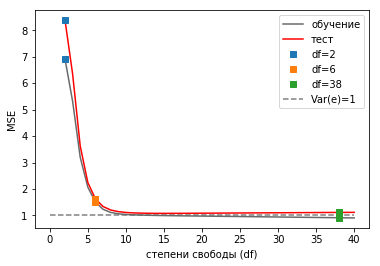

In [188]:
# график изменения MSE с увеличением df
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_train'], color='dimgrey', 
         marker='', label='обучение')
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_test'], color='red', 
         marker='', label='тест')
plt.plot([2, 2], [MSE_all_dfs.iloc[0]['MSE_train'], MSE_all_dfs.iloc[0]['MSE_test']],
         ls='', marker='s', label='df=2')
plt.plot([6, 6], [MSE_all_dfs.iloc[4]['MSE_train'], MSE_all_dfs.iloc[4]['MSE_test']],
         ls='', marker='s', label='df=6')
plt.plot([38, 38], [MSE_all_dfs.iloc[36]['MSE_train'], MSE_all_dfs.iloc[36]['MSE_test']],
         ls='', marker='s', label='df=38')
plt.hlines(1, 0, 40, linestyles='dashed', color='grey', label='Var(e)=1')
#  подписи осей
plt.xlabel('степени свободы (df)')
plt.ylabel('MSE')
# легенда
plt.legend(loc='best')

## $\color{red}{\text{Анализ графика для задачи 2}}$

* $n\_all = 500$

По графику мы можем видеть, что при заданном интервале кол-ва степеней свободы [0;40], наилучшее число степеней свободы действительно равно 15, где графики функций принимают свое минимальное значение.


Кривая MSE на обучающей выборке стабильно снижается с ростом узлов сплайна. Чем больше наблюдений, через которые прошёл сплайн, тем точнее модель. Это говорит о переобучении. Лучшую модель следуют выбирать по минимуму на кривой MSE на тестовой выборке.


---
# $\color{red}{\text{Анализ ошибки для задачи 2. Выводы:}}$

* $n\_all = 600$

Для данного числа наблюдений минимальная ошибка находится с числом степеней свободы = 17

    Df	MSE_train	MSE_test
    17	0.987517	0.904098

* $n\_all = 550$

Для данного числа наблюдений минимальная ошибка находится с числом степеней свободы = 14, как и раньше предполагалось, что надо брать меньшее кол-во степеней свободы чем 38

    Df	MSE_train	MSE_test
    14	1.02737	0.814475

* $n\_all = 500$

Для данного числа наблюдений минимальная ошибка находится с числом степеней свободы = 15, как и раньше предполагалось, что надо брать меньшее кол-во степеней свободы чем 38

    Df	MSE_train	MSE_test
    15	0.996472	1.080296
    
### **Вывод для задачи 2 по ошибке:**

Наименьшая ошибка на тестовой выборке достигается при кол-ве наблюдений $n\_all = 550$